In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, RocCurveDisplay, accuracy_score, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/content/output.csv', index_col='Unnamed: 0')

## Preprocessing

In [3]:
# Initialize classifiers
classifiers = {
    'logreg' : LogisticRegression(random_state=42, max_iter=1000),
    'random_forests' : RandomForestClassifier(random_state=42),
    'adaboost' : AdaBoostClassifier(random_state=42, base_estimator=DecisionTreeClassifier()),
    'xgboost' : XGBClassifier()
}

In [7]:
# X / y definition
X = df.drop(columns=['label'])
y = df['label']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X.values,
    y.values,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# SMOTE to address class imbalance (94/6)
sm = SMOTE()
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

# MinMaxScaler
mms = MinMaxScaler()
Xs_train = mms.fit_transform(X_train_sm)

# Note: A pipeline may clean up the code here with mms and our model process, 
# but during the testing phase with multiple models running with a single function, 
# for time complexity and computational purposes, 
# it may be better to scale before running the upcoming functions and fitting models.

## ML Model Testing

In [17]:
def run_baseline(model, 
                 X_train, y_train, X_test, y_test):
    """Return a dictionary of model performance indicators."""
    
    results = {}

    # Model Fit
    model_fit = model.fit(X_train, y_train)

    # Predict on the training and test sets
    y_pred_train = model_fit.predict(X_train)
    y_pred_test = model_fit.predict(X_test)
    
    # Train & test accuracy
    results['train_acc'] = accuracy_score(y_train, y_pred_train)
    results['test_acc'] = accuracy_score(y_test, y_pred_test)
    
    return results

def test_models(models, X_train, y_train, X_test, y_test,):
    """Returns DataFrame of baseline results 
       given a dictionary `models` of names/sklearn models."""
    results = {}
    
    # Fit each model and store how it performs on the test set
    for name, model in models.items():
        results[name] = run_baseline(model, 
                                     X_train, y_train, 
                                     X_test, y_test)

def fit_print_results(models, X_train, y_train, X_test, y_test):
    """Returns a classification report, confusion matrix, and ROC Curve for a user-input model and test data."""

    test_models(models, X_train, y_train, X_test, y_test)

    for model_name, model in models.items():

      # Generate Model Predictions
      y_preds = model.predict(X_test)
    
      # Print Classification Report
      print(classification_report(y_test, y_preds))

      # Print Confusion Matrix
      _, ax = plt.subplots(figsize=(9, 7))
      ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues', ax=ax, normalize='true')
      plt.title(f'{model_name} Confusion Matrix');

      # Print ROC Curve
      _, ax = plt.subplots(figsize=(16, 9))
      ax.title.set_text(f'{model_name} ROC Curve')
      ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c="red")
      RocCurveDisplay.from_predictions(y_test, y_preds, ax=ax);

              precision    recall  f1-score   support

           0       1.00      0.02      0.03    104230
           1       0.06      1.00      0.12      7016

    accuracy                           0.08    111246
   macro avg       0.53      0.51      0.08    111246
weighted avg       0.94      0.08      0.04    111246

              precision    recall  f1-score   support

           0       0.94      1.00      0.97    104230
           1       0.00      0.00      0.00      7016

    accuracy                           0.94    111246
   macro avg       0.47      0.50      0.48    111246
weighted avg       0.88      0.94      0.91    111246

              precision    recall  f1-score   support

           0       0.94      1.00      0.97    104230
           1       0.00      0.00      0.00      7016

    accuracy                           0.94    111246
   macro avg       0.47      0.50      0.48    111246
weighted avg       0.88      0.94      0.91    111246

              preci

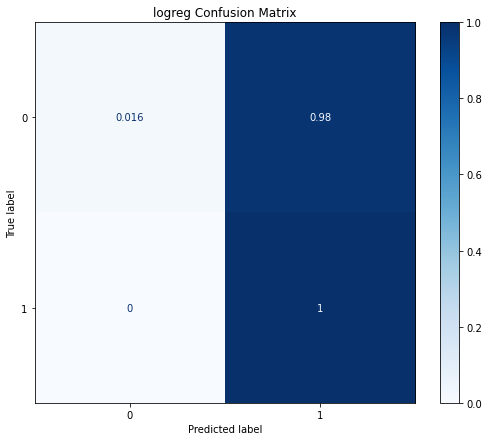

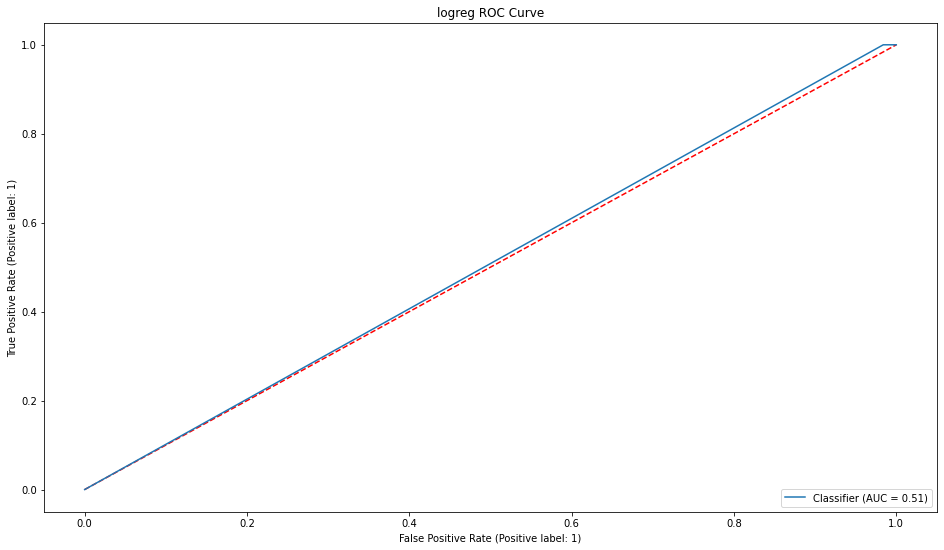

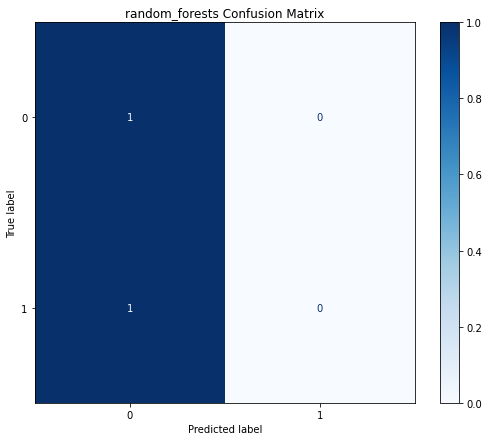

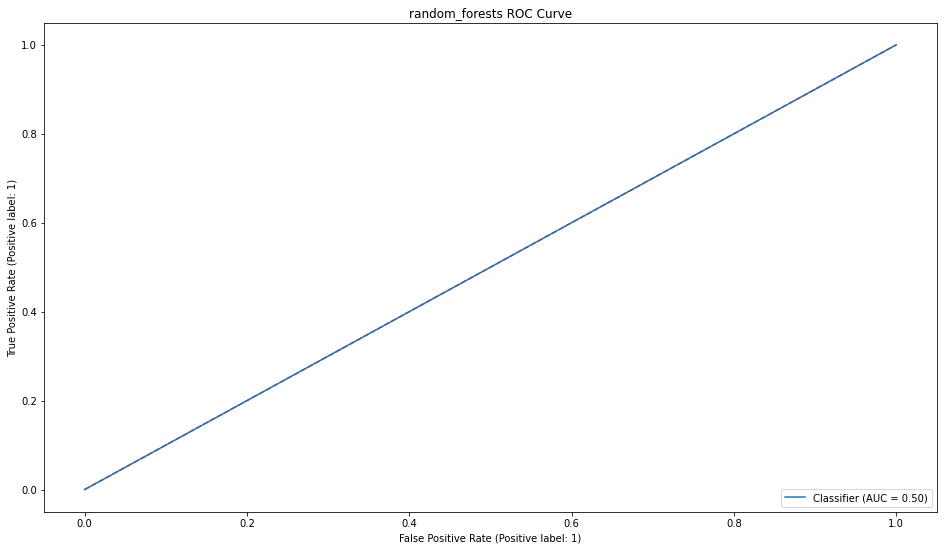

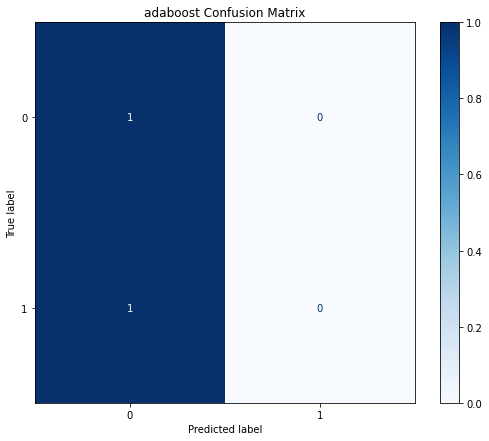

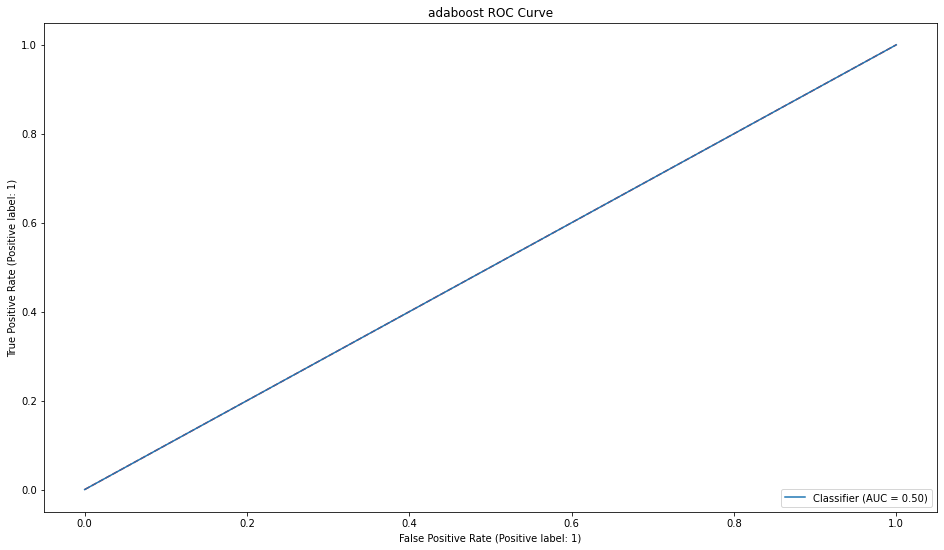

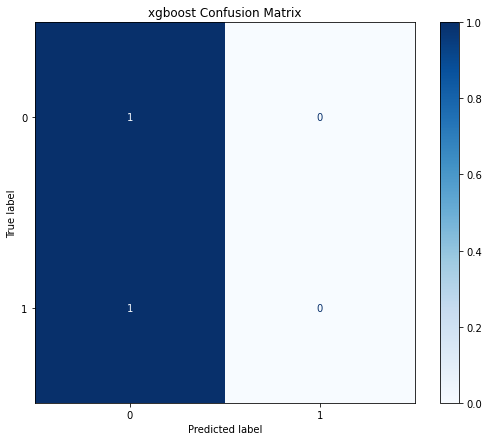

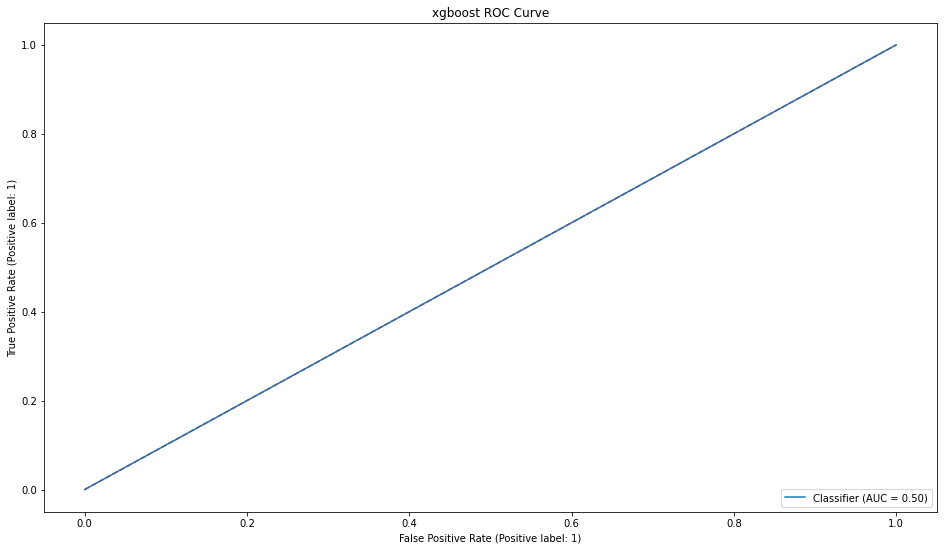

In [18]:
fit_print_results(classifiers, Xs_train, y_train_sm, X_test, y_test)

These simpler machine learning models seem to be unable to classify between authorized users and unauthorized attackers. Thus, a more computationally heavy approach most likely must be taken.